In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
sns.set()

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from scipy.spatial import distance as sci_distance
from sklearn import cluster as sk_cluster

In [2]:
# настройки отображения графиков
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
df = pd.read_csv(
    '/opt/kate_repo/real_data_analysis/digital_line/for_clustering.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27508 entries, 0 to 27507
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id_client                 27508 non-null  int64  
 1   InWeek_amount             27508 non-null  float64
 2   InWeek_SKU                27508 non-null  int64  
 3   Checkinmonth_average      27508 non-null  int64  
 4   Checkamount_mean          27508 non-null  float64
 5   Count_transac             27508 non-null  int64  
 6   Total_amount              27508 non-null  int64  
 7   Total_SKU_qnt             27508 non-null  float64
 8   Count_departments         27508 non-null  int64  
 9   Count_shop                27508 non-null  int64  
 10  Count_city                27508 non-null  int64  
 11  Tenure                    27508 non-null  int64  
 12  SKU_meanbytransac         27508 non-null  float64
 13  Amount_last6mnth          27508 non-null  float64
 14  Check_

In [5]:
df.iloc[:,21:35].head()

,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount
0,175,2748,0.22,278,3490,0.28,420,4096,0.33,161,1060,0.09,80,1004
1,199,4098,0.32,279,4027,0.31,407,3304,0.25,93,1055,0.08,46,476
2,18,121,0.04,62,2013,0.68,39,160,0.05,34,335,0.11,17,335
3,798,5177,0.26,500,5094,0.26,995,7777,0.40,129,1089,0.06,64,539
4,59,639,0.26,73,808,0.33,90,265,0.11,22,664,0.27,11,106


In [6]:
# Уникальные значения для идентификации категориальных признаков
unique_val = df.nunique()
unique_val

Id_client                   27508
InWeek_amount               20343
InWeek_SKU                     50
Checkinmonth_average           10
Checkamount_mean            17546
Count_transac                 435
Total_amount                13869
Total_SKU_qnt                2256
Count_departments              32
Count_shop                     34
Count_city                      8
Tenure                         11
SKU_meanbytransac              29
Amount_last6mnth            24722
Check_qntlast6mnth             71
SKU_price_mean              27508
Gender                          2
Age                            85
Age_group                       6
Interval_visit                 31
Days_pastvisit                 33
Cat_householdchem_qnt         694
Cat_householdchem_amount     5604
Cat_householdchem_share        71
Cat_careproducts_qnt          815
Cat_careproducts_amount      7553
Cat_careproducts_share         89
Cat_toiletries_qnt           1338
Cat_toiletries_amount        6899
Cat_toiletries

In [7]:
# Список долей отсутствующих записей для каждого признака
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if pct_missing > 0:
        print('{} - {}%'.format(col, round(pct_missing * 100)))

Gender - 1%
Age - 1%
Age_group - 1%


In [8]:
# Удаление строк с отсутствующими значениями
filtered_df = df[df['Gender'].isnull()]
df = df.drop(filtered_df.index)

In [9]:
# описательная статистика данных
df.describe()

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,...,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
count,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,...,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000
mean,210554.677412,314.727811,31.429677,2.558844,159.693143,82.136795,9585.637217,762.858547,26.738915,3.857703,...,0.058574,0.999963,0.547585,40.356695,8.388125,936.866392,0.998056,0.921003,2.003741,2.003741
std,121847.905725,144.464145,11.376459,1.195365,111.530548,62.795554,4712.872902,451.270900,4.036792,2.760003,...,0.049080,0.006056,0.497740,23.757077,7.202557,590.731978,0.044046,0.269738,0.776111,0.776111
min,5743.000000,34.470000,2.000000,2.000000,10.240000,4.000000,739.000000,33.000000,7.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,99.000000,0.000000,0.000000,1.000000,1.000000
25%,105584.500000,212.995000,23.000000,2.000000,85.935000,39.000000,5889.000000,431.000000,24.000000,2.000000,...,0.020000,1.000000,0.000000,22.000000,3.000000,447.800000,1.000000,1.000000,1.000000,1.000000
50%,212782.000000,289.200000,31.000000,2.000000,128.850000,66.000000,8809.000000,673.000000,27.000000,3.000000,...,0.050000,1.000000,1.000000,37.000000,6.000000,827.110000,1.000000,1.000000,2.000000,2.000000
75%,309896.500000,385.205000,41.000000,2.000000,199.415000,108.000000,12622.000000,1001.500000,30.000000,5.000000,...,0.080000,1.000000,1.000000,56.000000,11.000000,1330.255000,1.000000,1.000000,3.000000,3.000000
max,830188.000000,2180.010000,51.000000,20.000000,1326.120000,990.000000,22748.000000,5058.000000,38.000000,46.000000,...,0.890000,1.000000,1.000000,180.000000,112.000000,2478.470000,1.000000,1.000000,3.000000,3.000000


In [10]:
# проверка на уникальность ID
from collections import Counter
[k for k, v in Counter(df['Id_client']).items() if v > 1]

[]

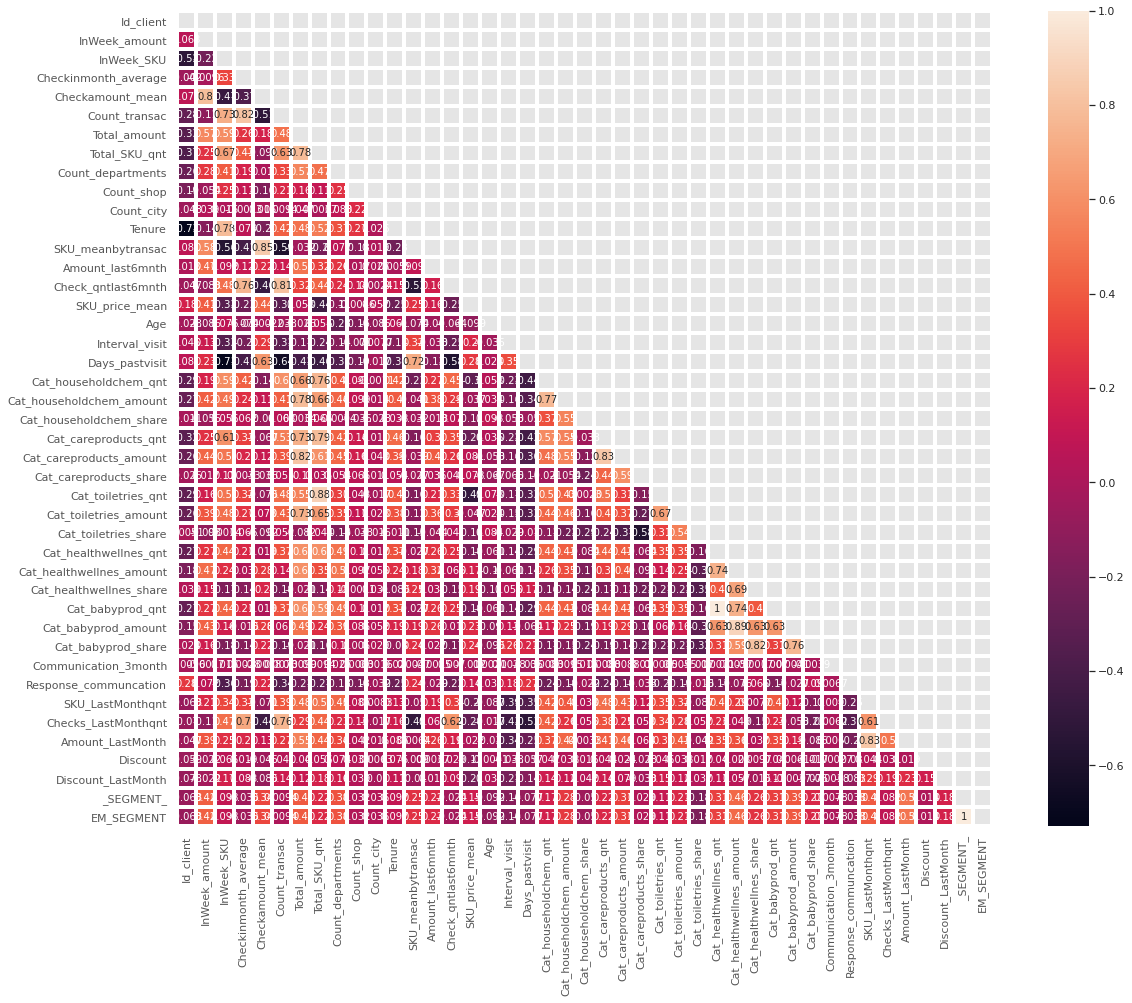

In [11]:
# матрица корреляции для отбора параметров для алгоритма кластеризации
fig, ax = plt.subplots(figsize=(20, 15))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('dark'):
    ax = sns.heatmap(corr,
                     mask=mask,
                     square=True,
                     cbar=True,
                     annot=True,
                     linewidths=3)

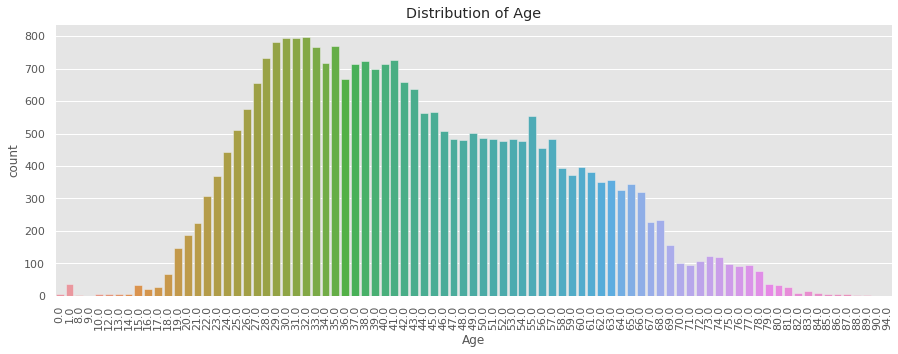

In [12]:
# оценка распределения данных о возрасте
sns.countplot(x='Age', data=df)
plt.title('Distribution of Age')
plt.xticks(rotation=90);

In [13]:
# Убрать потребителей с возрастом менее 8 лет как выбросы
unrelevant_info = df[df['Age'] < 8]
df = df.drop(unrelevant_info.index)

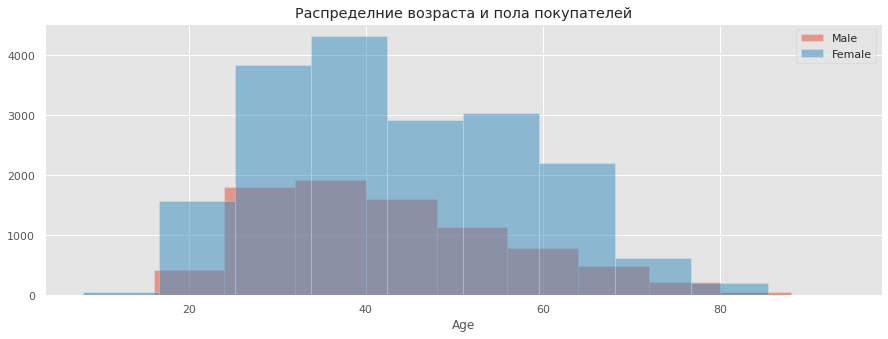

In [14]:
# Возраст и пол
plt.hist('Age', data=df[df['Gender'] == 'M'], alpha=0.5, label='Male')
plt.hist('Age', data=df[df['Gender'] == 'F'], alpha=0.5, label='Female')
plt.title('Распределние возраста и пола покупателей')
plt.xlabel('Age')
plt.legend();

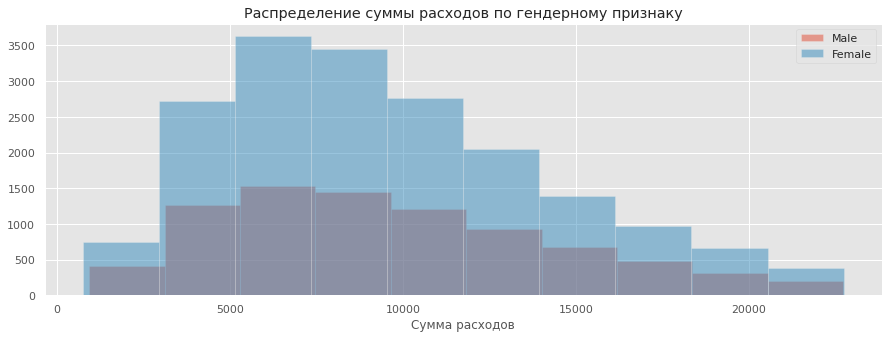

In [15]:
# Расходы и пол
plt.hist('Total_amount', data=df[df['Gender'] == 'M'], alpha=0.5, label='Male')
plt.hist('Total_amount',
         data=df[df['Gender'] == 'F'],
         alpha=0.5,
         label='Female')
plt.title('Распределение суммы расходов по гендерному признаку')
plt.xlabel('Сумма расходов')
plt.legend()

In [16]:
# Средняя сумма расходов по гендеру
male_df = df[df['Gender'] == 'M']
female_df = df[df['Gender'] == 'F']

print('Средний расход мужчин: %.3f' % male_df['Total_amount'].mean())
print('Средний расход женщин: %.3f' % female_df['Total_amount'].mean())

Средний расход мужчин: 9717.955
Средний расход женщин: 9526.777


/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Карта отношений возраста, пола и расходов')

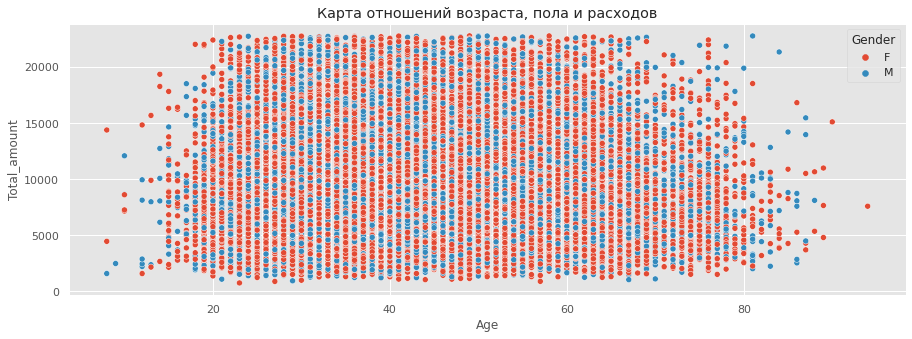

In [17]:
# Возраст, пол и сумма расходов
sns.scatterplot('Age', 'Total_amount', hue='Gender', data=df)
plt.title('Карта отношений возраста, пола и расходов')

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Зависимость между суммой и частотой покупок')

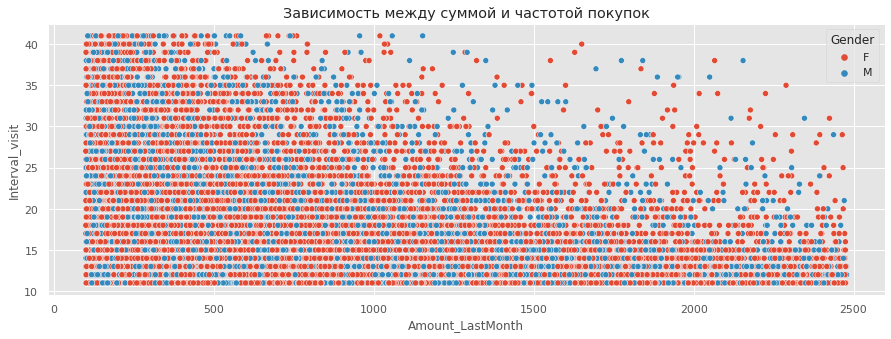

In [18]:
# сумма и давность покупок
sns.scatterplot('Amount_LastMonth', 'Interval_visit', hue='Gender', data=df)
plt.title('Зависимость между суммой и частотой покупок')

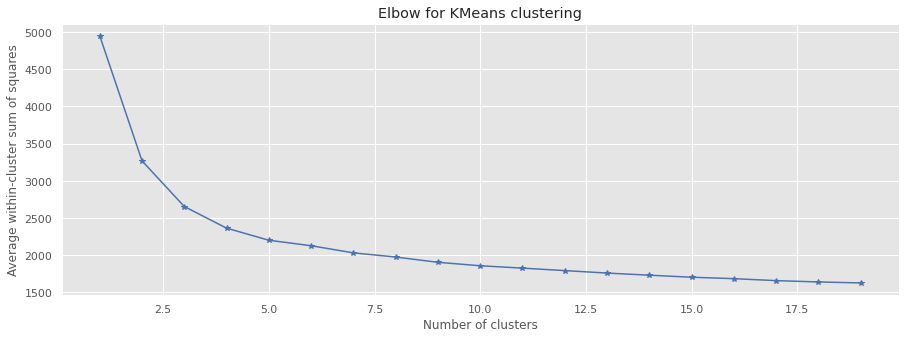

In [19]:
# Чтобы определить число кластеров для алгоритма, используется график значений сумм квадратов внутри групп 
# по числу извлеченных кластеров. Необходимое число кластеров будет находиться на изгибе графика.

columns = [
"InWeek_amount", "Count_transac", "Total_amount", "Count_departments", "Count_shop",           
"Count_city","Tenure", "Amount_last6mnth", "Check_qntlast6mnth", "SKU_price_mean", "Age", "Interval_visit",
"Cat_householdchem_amount", "Cat_careproducts_amount", "Cat_toiletries_amount", "Cat_healthwellnes_amount",
"Communication_3month", "Response_communcation", "Amount_LastMonth", "Discount", "_SEGMENT_","Cat_babyprod_amount"
]
cdata = df[columns]
K = range(1, 20)
KM = (sk_cluster.KMeans(n_clusters=k).fit(cdata) for k in K)
centroids = (k.cluster_centers_ for k in KM)

D_k = (sci_distance.cdist(cdata, cent, 'euclidean') for cent in centroids)
dist = (np.min(D, axis=1) for D in D_k)
avgWithinSS = [sum(d) / cdata.shape[0] for d in dist]
plt.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

In [20]:
# Данные о кластерах
n_clusters = 4

means_cluster = sk_cluster.KMeans(n_clusters=n_clusters, random_state=111)
est = means_cluster.fit(df[columns])
clusters = est.labels_
df['cluster'] = clusters

# Значения показателей в кластерах

for c in range(n_clusters):
    cluster_members = df[df['cluster'] == c][:]
    print('Cluster{}(n={}):'.format(c, len(cluster_members)))
    print('-' * 17)

Cluster0(n=9049):
-----------------
Cluster1(n=3505):
-----------------
Cluster2(n=8215):
-----------------
Cluster3(n=6453):
-----------------


In [21]:
# Средние значения расходов на группы товаров в кластерах 
group_clients = df.groupby(['cluster']).mean()
group_clients[["Cat_healthwellnes_amount", "Cat_careproducts_amount", "Cat_toiletries_amount",
           "Cat_healthwellnes_amount","Cat_babyprod_amount"]]

,Cat_healthwellnes_amount,Cat_careproducts_amount,Cat_toiletries_amount,Cat_healthwellnes_amount,Cat_babyprod_amount
cluster,,,,,
0,641.531661,2799.210189,2574.537960,641.531661,487.720522
1,1344.673039,6303.018260,5394.462767,1344.673039,1030.414551
2,363.869994,1409.638344,1453.635666,363.869994,286.931589
3,969.733147,4316.002170,3852.707733,969.733147,740.274601
